In [1]:
from collections import defaultdict
import functools
from glob import glob
import os
import re

import numpy as np
from matplotlib import pylab as plt
import torch
try:
    import tqdm
    progress = tqdm.tqdm
except ModuleNotFoundError:
    progress = lambda x, *args : x

from odenet import refine_train
from odenet import ode_models
from odenet import datasets
from odenet import odenet_cifar10
from odenet import plotting
from odenet import helper

In [2]:
import importlib
importlib.reload(refine_train)
importlib.reload(ode_models)
importlib.reload(odenet_cifar10)
importlib.reload(datasets)

<module 'odenet.datasets' from '/home/ubuntu/afq_odenet/ODENet/odenet/datasets.py'>

In [3]:
legend_name = lambda fname : re.search(r"ARCH(.*)", fname)[1]

In [72]:
dirs = glob('results/*CIFAR*160*') + glob('results/*CIFAR*200*')
dirs = sorted(dirs, key = lambda x : os.stat(x).st_mtime)[:]
results = { name: torch.load(name) for name in dirs }
dirs

['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.05-200-[40, 80]-0.0-Backprop-NormalInit-SEED-1.pkl',
 'results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-8-1.0-1-piecewise-LEARN-0.05-200-[]-0.0-Backprop-NormalInit-SEED-1.pkl',
 'results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.05-160-[50, 100]-0.0-Backprop-NormalInit-SEED-1.pkl',
 'results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.05-160-[60, 120]-0.0-Backprop-NormalInit-SEED-1.pkl',
 'results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-1-1.0-1-piecewise-LEARN-0.05-160-[10, 40, 60, 80]-0.0-Backprop-NormalInit-SEED-1.pkl']

# Just stating the latest loaded plots

results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.05-200-[40, 80]-0.0-Backprop-NormalInit-SEED-1.pkl 0.9144
results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-8-1.0-1-piecewise-LEARN-0.05-200-[]-0.0-Backprop-NormalInit-SEED-1.pkl 0.9128
results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.05-160-[50, 100]-0.0-Backprop-NormalInit-SEED-1.pkl 0.9079
results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.05-160-[60, 120]-0.0-Backprop-NormalInit-SEED-1.pkl 0.9141
results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-1-1.0-1-piecewise-LEARN-0.05-160-[10, 40, 60, 80]-0.0-Backprop-NormalInit-SEED-1.pkl 0.9112


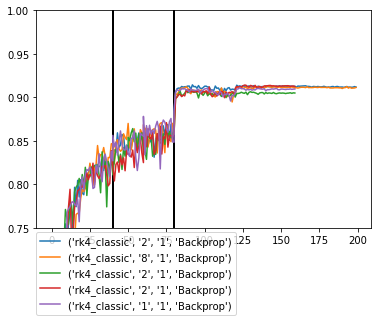

In [75]:
for name, result in results.items():
    #plt.plot(result.train_acc, label=legend_name(name))
    x,y = zip(*result.test_acc)
    plt.plot(x,y, '-', label=legend_name(name))
    try:
        x,y = zip(*result.train_acc)
        plt.plot(x,y, '--', label=legend_name(name))
    except: pass
    print((name),
          max(list(zip(*result.test_acc))[1]),)
          #max(list(zip(*result.train_acc))[1]))
    plt.vlines([40,80],0,1)
plt.ylim(0.75,1)
plt.legend(loc=(0,-0.4))

# Plots for Adjoint performance

In [57]:
def legend_name(fname):
    mat = re.search(r".*(euler|rk4_classic)-([0-9])-.*([0-9])-piecewise.*(Adjoint|Backprop).*-NormalInit", fname)
    return mat[1], mat[2], mat[3], mat[4]
for name, result in results.items():
    print(legend_name(name), "|", np.average(result.epoch_times), "s")

('rk4_classic', '2', '1', 'Backprop') | 55.18050939145003 s
('rk4_classic', '8', '1', 'Backprop') | 73.52393591061492 s
('rk4_classic', '2', '1', 'Backprop') | 45.121386028987175 s


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


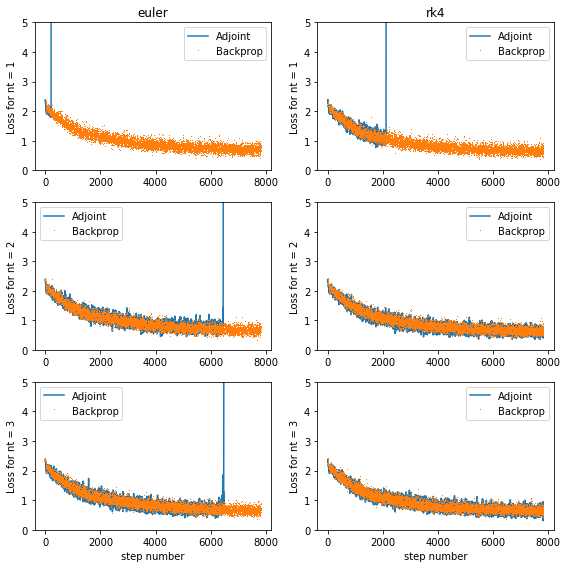

In [124]:
plt.figure(figsize=(8,8))
for i,(name, result) in enumerate(results.items()):
    if "euler" in name:
        horiz = 0
    else:
        horiz = 1
    if "-1-" in name:
        vert = 0
    elif "-2-" in name:
        vert = 1
    else:
        vert = 2

    plt.subplot(3,2,1+horiz+2*vert)
    if horiz==0 and vert==0:
        plt.title("euler")
    if horiz==1 and vert==0:
        plt.title("rk4")
    if vert==2:
        plt.xlabel("step number")
    plt.ylabel(f"Loss for nt = { vert+1}")
    plt.plot(result.losses,
             '-' if "Adjoint" in name else ',',
             label="Adjoint" if "Adjoint" in name else "Backprop")
    #plt.vlines(result.refine_steps, 0,1, linestyle='dashed')
    plt.legend()
    plt.ylim(0.,5)
plt.tight_layout()


ValueError: not enough values to unpack (expected 2, got 0)

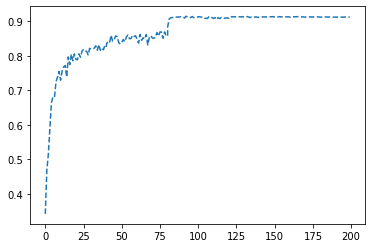

In [58]:
for name, result in results.items():
    #plt.plot(result.train_acc, label=legend_name(name))
    x,y = zip(*result.test_acc)
    plt.plot(x,y, '--', label=legend_name(name))
    x,y = zip(*result.train_acc)
    plt.plot(x,y, '--', label=legend_name(name))
    print((name), max(result.test_acc))
    plt.vlines([50,],0,1)
plt.ylim(0.,1)
#plt.legend(loc=(0,-0.4))

# Manifestation Invariance

In [9]:
refset,trainset,trainloader,testset,testloader = \
    datasets.get_dataset("CIFAR10",root='../data/')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [10]:
def set_ode_config(model, n_steps, scheme, use_adjoint=False):
    for net_idx in range(len(model.net)):
        try:
            model.net[net_idx].set_n_time_steps(n_steps)
            model.net[net_idx].scheme = scheme
        except AttributeError:
            pass

In [14]:
from SimDataDB import SimDataDB

This function is permanantly cached with a database. Delete the database to refresh the cache.

In [77]:
sdb = SimDataDB("results/manifestation_study.sqlite")

In [78]:
@sdb.Decorate(
    "fmnist",
    [("network","STRING"),("scheme","STRING"),("num_time","INT"),],
    [("train_acc","INT")])
@torch.no_grad()
def calc_acc_for_scheme_nt(name, scheme, nt):
    mod = results[name].model_list[-1]
    mod.eval()
    set_ode_config(mod, nt, scheme)
    return [refine_train.calculate_accuracy(mod, testloader)]

CREATE TABLE IF NOT EXISTS fmnist ( network STRING, scheme STRING, num_time INT, train_acc INT, timestamp VARCHAR(30), runtime FLOAT );


Here we query/populate the database and pack it into nested dictionaries.

In [79]:
test_sweep = defaultdict( lambda : {} )
with torch.no_grad():
    for name, result in results.items():
        accs_for_scheme = {}
        for scheme in ('euler', 'midpoint','rk4'):
            accs = []
            for nt in progress(range(1, 21, 1), f"{legend_name(name)}, {scheme}"):
                accs.append((nt, calc_acc_for_scheme_nt(name, scheme, nt)[0]))
            accs_for_scheme[scheme] = accs
        test_sweep[name].update(accs_for_scheme)
test_sweep

('rk4_classic', '2', '1', 'Backprop'), euler:   5%|▌         | 1/20 [00:01<00:26,  1.38s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.05-160-[60, 120]-0.0-Backprop-NormalInit-SEED-1.pkl', 'euler', 1, 0.1131, datetime.datetime(2020, 5, 15, 19, 38, 9, 473933), 1.37693190574646]


('rk4_classic', '2', '1', 'Backprop'), euler:  10%|█         | 2/20 [00:02<00:25,  1.43s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.05-160-[60, 120]-0.0-Backprop-NormalInit-SEED-1.pkl', 'euler', 2, 0.19, datetime.datetime(2020, 5, 15, 19, 38, 10, 858316), 1.5184497833251953]


('rk4_classic', '2', '1', 'Backprop'), euler:  15%|█▌        | 3/20 [00:04<00:27,  1.61s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.05-160-[60, 120]-0.0-Backprop-NormalInit-SEED-1.pkl', 'euler', 3, 0.4172, datetime.datetime(2020, 5, 15, 19, 38, 12, 383008), 2.035487174987793]


('rk4_classic', '2', '1', 'Backprop'), euler:  20%|██        | 4/20 [00:07<00:30,  1.91s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.05-160-[60, 120]-0.0-Backprop-NormalInit-SEED-1.pkl', 'euler', 4, 0.7679, datetime.datetime(2020, 5, 15, 19, 38, 14, 424558), 2.6001780033111572]


('rk4_classic', '2', '1', 'Backprop'), euler:  25%|██▌       | 5/20 [00:10<00:33,  2.26s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.05-160-[60, 120]-0.0-Backprop-NormalInit-SEED-1.pkl', 'euler', 5, 0.7587, datetime.datetime(2020, 5, 15, 19, 38, 17, 31379), 3.0836997032165527]


('rk4_classic', '2', '1', 'Backprop'), euler:  30%|███       | 6/20 [00:13<00:35,  2.55s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.05-160-[60, 120]-0.0-Backprop-NormalInit-SEED-1.pkl', 'euler', 6, 0.8097, datetime.datetime(2020, 5, 15, 19, 38, 20, 121590), 3.2141802310943604]


('rk4_classic', '2', '1', 'Backprop'), euler:  35%|███▌      | 7/20 [00:17<00:37,  2.91s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.05-160-[60, 120]-0.0-Backprop-NormalInit-SEED-1.pkl', 'euler', 7, 0.7994, datetime.datetime(2020, 5, 15, 19, 38, 23, 343579), 3.735090732574463]


('rk4_classic', '2', '1', 'Backprop'), euler:  40%|████      | 8/20 [00:22<00:41,  3.46s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.05-160-[60, 120]-0.0-Backprop-NormalInit-SEED-1.pkl', 'euler', 8, 0.8834, datetime.datetime(2020, 5, 15, 19, 38, 27, 84746), 4.748767614364624]


('rk4_classic', '2', '1', 'Backprop'), euler:  45%|████▌     | 9/20 [00:27<00:44,  4.02s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.05-160-[60, 120]-0.0-Backprop-NormalInit-SEED-1.pkl', 'euler', 9, 0.8611, datetime.datetime(2020, 5, 15, 19, 38, 31, 840991), 5.320724964141846]


('rk4_classic', '2', '1', 'Backprop'), euler:  50%|█████     | 10/20 [00:33<00:44,  4.45s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.05-160-[60, 120]-0.0-Backprop-NormalInit-SEED-1.pkl', 'euler', 10, 0.8761, datetime.datetime(2020, 5, 15, 19, 38, 37, 168394), 5.429344654083252]


('rk4_classic', '2', '1', 'Backprop'), euler:  55%|█████▌    | 11/20 [00:38<00:43,  4.87s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.05-160-[60, 120]-0.0-Backprop-NormalInit-SEED-1.pkl', 'euler', 11, 0.8684, datetime.datetime(2020, 5, 15, 19, 38, 42, 605270), 5.848018169403076]


('rk4_classic', '2', '1', 'Backprop'), euler:  60%|██████    | 12/20 [00:45<00:43,  5.48s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.05-160-[60, 120]-0.0-Backprop-NormalInit-SEED-1.pkl', 'euler', 12, 0.8984, datetime.datetime(2020, 5, 15, 19, 38, 48, 461879), 6.882584571838379]


('rk4_classic', '2', '1', 'Backprop'), euler:  65%|██████▌   | 13/20 [00:52<00:41,  5.90s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.05-160-[60, 120]-0.0-Backprop-NormalInit-SEED-1.pkl', 'euler', 13, 0.8863, datetime.datetime(2020, 5, 15, 19, 38, 55, 352739), 6.886423587799072]


('rk4_classic', '2', '1', 'Backprop'), euler:  70%|███████   | 14/20 [01:00<00:37,  6.32s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.05-160-[60, 120]-0.0-Backprop-NormalInit-SEED-1.pkl', 'euler', 14, 0.8935, datetime.datetime(2020, 5, 15, 19, 39, 2, 246326), 7.304866313934326]


('rk4_classic', '2', '1', 'Backprop'), euler:  75%|███████▌  | 15/20 [01:08<00:34,  6.93s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.05-160-[60, 120]-0.0-Backprop-NormalInit-SEED-1.pkl', 'euler', 15, 0.8859, datetime.datetime(2020, 5, 15, 19, 39, 9, 557433), 8.331344842910767]


('rk4_classic', '2', '1', 'Backprop'), euler:  80%|████████  | 16/20 [01:16<00:29,  7.26s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.05-160-[60, 120]-0.0-Backprop-NormalInit-SEED-1.pkl', 'euler', 16, 0.905, datetime.datetime(2020, 5, 15, 19, 39, 17, 896409), 8.033442974090576]


('rk4_classic', '2', '1', 'Backprop'), euler:  85%|████████▌ | 17/20 [01:25<00:23,  7.93s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.05-160-[60, 120]-0.0-Backprop-NormalInit-SEED-1.pkl', 'euler', 17, 0.8971, datetime.datetime(2020, 5, 15, 19, 39, 25, 936397), 9.48472547531128]


('rk4_classic', '2', '1', 'Backprop'), euler:  90%|█████████ | 18/20 [01:34<00:16,  8.26s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.05-160-[60, 120]-0.0-Backprop-NormalInit-SEED-1.pkl', 'euler', 18, 0.9019, datetime.datetime(2020, 5, 15, 19, 39, 35, 427888), 9.02864146232605]


('rk4_classic', '2', '1', 'Backprop'), euler:  95%|█████████▌| 19/20 [01:45<00:08,  8.92s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.05-160-[60, 120]-0.0-Backprop-NormalInit-SEED-1.pkl', 'euler', 19, 0.8971, datetime.datetime(2020, 5, 15, 19, 39, 44, 462866), 10.45280408859253]


('rk4_classic', '2', '1', 'Backprop'), euler: 100%|██████████| 20/20 [01:55<00:00,  5.78s/it]
('rk4_classic', '2', '1', 'Backprop'), midpoint:   0%|          | 0/20 [00:00<?, ?it/s]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.05-160-[60, 120]-0.0-Backprop-NormalInit-SEED-1.pkl', 'euler', 20, 0.9066, datetime.datetime(2020, 5, 15, 19, 39, 54, 923288), 10.047810554504395]


('rk4_classic', '2', '1', 'Backprop'), midpoint:   5%|▌         | 1/20 [00:01<00:26,  1.42s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.05-160-[60, 120]-0.0-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 1, 0.1616, datetime.datetime(2020, 5, 15, 19, 40, 4, 980039), 1.4109115600585938]


('rk4_classic', '2', '1', 'Backprop'), midpoint:  10%|█         | 2/20 [00:03<00:29,  1.64s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.05-160-[60, 120]-0.0-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 2, 0.5427, datetime.datetime(2020, 5, 15, 19, 40, 6, 397253), 2.1477901935577393]


('rk4_classic', '2', '1', 'Backprop'), midpoint:  15%|█▌        | 3/20 [00:06<00:34,  2.04s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.05-160-[60, 120]-0.0-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 3, 0.7063, datetime.datetime(2020, 5, 15, 19, 40, 8, 551999), 2.955584764480591]


('rk4_classic', '2', '1', 'Backprop'), midpoint:  20%|██        | 4/20 [00:10<00:41,  2.57s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.05-160-[60, 120]-0.0-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 4, 0.8943, datetime.datetime(2020, 5, 15, 19, 40, 11, 515215), 3.81941556930542]


('rk4_classic', '2', '1', 'Backprop'), midpoint:  25%|██▌       | 5/20 [00:14<00:47,  3.16s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.05-160-[60, 120]-0.0-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 5, 0.8645, datetime.datetime(2020, 5, 15, 19, 40, 15, 341179), 4.529122829437256]


('rk4_classic', '2', '1', 'Backprop'), midpoint:  30%|███       | 6/20 [00:19<00:50,  3.61s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.05-160-[60, 120]-0.0-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 6, 0.8913, datetime.datetime(2020, 5, 15, 19, 40, 19, 877333), 4.666319131851196]


('rk4_classic', '2', '1', 'Backprop'), midpoint:  35%|███▌      | 7/20 [00:25<00:57,  4.41s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.05-160-[60, 120]-0.0-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 7, 0.904, datetime.datetime(2020, 5, 15, 19, 40, 24, 549925), 6.263889312744141]


('rk4_classic', '2', '1', 'Backprop'), midpoint:  40%|████      | 8/20 [00:32<01:02,  5.20s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.05-160-[60, 120]-0.0-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 8, 0.909, datetime.datetime(2020, 5, 15, 19, 40, 30, 820541), 7.035632371902466]


('rk4_classic', '2', '1', 'Backprop'), midpoint:  45%|████▌     | 9/20 [00:40<01:03,  5.79s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.05-160-[60, 120]-0.0-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 9, 0.9062, datetime.datetime(2020, 5, 15, 19, 40, 37, 863080), 7.167768955230713]


('rk4_classic', '2', '1', 'Backprop'), midpoint:  50%|█████     | 10/20 [00:49<01:07,  6.75s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.05-160-[60, 120]-0.0-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 10, 0.9063, datetime.datetime(2020, 5, 15, 19, 40, 45, 37656), 8.96546459197998]


('rk4_classic', '2', '1', 'Backprop'), midpoint:  55%|█████▌    | 11/20 [00:58<01:07,  7.44s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.05-160-[60, 120]-0.0-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 11, 0.91, datetime.datetime(2020, 5, 15, 19, 40, 54, 9706), 9.066731214523315]


('rk4_classic', '2', '1', 'Backprop'), midpoint:  60%|██████    | 12/20 [01:08<01:05,  8.21s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.05-160-[60, 120]-0.0-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 12, 0.9122, datetime.datetime(2020, 5, 15, 19, 41, 3, 83338), 9.994592666625977]


('rk4_classic', '2', '1', 'Backprop'), midpoint:  65%|██████▌   | 13/20 [01:18<01:02,  8.95s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.05-160-[60, 120]-0.0-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 13, 0.9084, datetime.datetime(2020, 5, 15, 19, 41, 13, 85732), 10.681300401687622]


('rk4_classic', '2', '1', 'Backprop'), midpoint:  70%|███████   | 14/20 [01:30<00:59,  9.87s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.05-160-[60, 120]-0.0-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 14, 0.9103, datetime.datetime(2020, 5, 15, 19, 41, 23, 774525), 11.994487285614014]


('rk4_classic', '2', '1', 'Backprop'), midpoint:  75%|███████▌  | 15/20 [01:42<00:52, 10.47s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.05-160-[60, 120]-0.0-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 15, 0.9123, datetime.datetime(2020, 5, 15, 19, 41, 35, 775342), 11.856964588165283]


('rk4_classic', '2', '1', 'Backprop'), midpoint:  80%|████████  | 16/20 [01:56<00:45, 11.39s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.05-160-[60, 120]-0.0-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 16, 0.9124, datetime.datetime(2020, 5, 15, 19, 41, 47, 639587), 13.523665189743042]


('rk4_classic', '2', '1', 'Backprop'), midpoint:  85%|████████▌ | 17/20 [02:09<00:36, 12.10s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.05-160-[60, 120]-0.0-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 17, 0.9108, datetime.datetime(2020, 5, 15, 19, 42, 1, 170674), 13.764539003372192]


('rk4_classic', '2', '1', 'Backprop'), midpoint:  90%|█████████ | 18/20 [02:24<00:25, 12.79s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.05-160-[60, 120]-0.0-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 18, 0.9117, datetime.datetime(2020, 5, 15, 19, 42, 14, 941984), 14.38559627532959]


('rk4_classic', '2', '1', 'Backprop'), midpoint:  95%|█████████▌| 19/20 [02:40<00:13, 13.75s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.05-160-[60, 120]-0.0-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 19, 0.9125, datetime.datetime(2020, 5, 15, 19, 42, 29, 334644), 15.972791194915771]


('rk4_classic', '2', '1', 'Backprop'), rk4:   0%|          | 0/20 [00:00<?, ?it/s]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.05-160-[60, 120]-0.0-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 20, 0.9124, datetime.datetime(2020, 5, 15, 19, 42, 45, 315001), 16.481867790222168]


('rk4_classic', '2', '1', 'Backprop'), rk4:   5%|▌         | 1/20 [00:02<00:39,  2.06s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.05-160-[60, 120]-0.0-Backprop-NormalInit-SEED-1.pkl', 'rk4', 1, 0.295, datetime.datetime(2020, 5, 15, 19, 43, 1, 805643), 2.052273750305176]


('rk4_classic', '2', '1', 'Backprop'), rk4:  10%|█         | 2/20 [00:05<00:42,  2.39s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.05-160-[60, 120]-0.0-Backprop-NormalInit-SEED-1.pkl', 'rk4', 2, 0.9039, datetime.datetime(2020, 5, 15, 19, 43, 3, 865105), 3.1469035148620605]


('rk4_classic', '2', '1', 'Backprop'), rk4:  15%|█▌        | 3/20 [00:10<00:53,  3.13s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.05-160-[60, 120]-0.0-Backprop-NormalInit-SEED-1.pkl', 'rk4', 3, 0.9069, datetime.datetime(2020, 5, 15, 19, 43, 7, 18510), 4.841397762298584]


('rk4_classic', '2', '1', 'Backprop'), rk4:  20%|██        | 4/20 [00:16<01:07,  4.23s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.05-160-[60, 120]-0.0-Backprop-NormalInit-SEED-1.pkl', 'rk4', 4, 0.9112, datetime.datetime(2020, 5, 15, 19, 43, 11, 866622), 6.81176233291626]


('rk4_classic', '2', '1', 'Backprop'), rk4:  25%|██▌       | 5/20 [00:24<01:20,  5.39s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.05-160-[60, 120]-0.0-Backprop-NormalInit-SEED-1.pkl', 'rk4', 5, 0.9091, datetime.datetime(2020, 5, 15, 19, 43, 18, 684817), 8.06731128692627]


('rk4_classic', '2', '1', 'Backprop'), rk4:  30%|███       | 6/20 [00:34<01:31,  6.55s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.05-160-[60, 120]-0.0-Backprop-NormalInit-SEED-1.pkl', 'rk4', 6, 0.913, datetime.datetime(2020, 5, 15, 19, 43, 26, 759395), 9.251078128814697]


('rk4_classic', '2', '1', 'Backprop'), rk4:  35%|███▌      | 7/20 [00:45<01:43,  7.97s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.05-160-[60, 120]-0.0-Backprop-NormalInit-SEED-1.pkl', 'rk4', 7, 0.9112, datetime.datetime(2020, 5, 15, 19, 43, 36, 17113), 11.294060468673706]


('rk4_classic', '2', '1', 'Backprop'), rk4:  40%|████      | 8/20 [00:57<01:50,  9.19s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.05-160-[60, 120]-0.0-Backprop-NormalInit-SEED-1.pkl', 'rk4', 8, 0.9123, datetime.datetime(2020, 5, 15, 19, 43, 47, 317968), 12.00682282447815]


('rk4_classic', '2', '1', 'Backprop'), rk4:  45%|████▌     | 9/20 [01:11<01:55, 10.50s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.05-160-[60, 120]-0.0-Backprop-NormalInit-SEED-1.pkl', 'rk4', 9, 0.9122, datetime.datetime(2020, 5, 15, 19, 43, 59, 331386), 13.555888414382935]


('rk4_classic', '2', '1', 'Backprop'), rk4:  50%|█████     | 10/20 [01:27<02:01, 12.15s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.05-160-[60, 120]-0.0-Backprop-NormalInit-SEED-1.pkl', 'rk4', 10, 0.9129, datetime.datetime(2020, 5, 15, 19, 44, 12, 893772), 16.01203727722168]


('rk4_classic', '2', '1', 'Backprop'), rk4:  55%|█████▌    | 11/20 [01:43<02:01, 13.49s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.05-160-[60, 120]-0.0-Backprop-NormalInit-SEED-1.pkl', 'rk4', 11, 0.912, datetime.datetime(2020, 5, 15, 19, 44, 28, 912176), 16.6009738445282]


('rk4_classic', '2', '1', 'Backprop'), rk4:  60%|██████    | 12/20 [02:01<01:59, 14.90s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.05-160-[60, 120]-0.0-Backprop-NormalInit-SEED-1.pkl', 'rk4', 12, 0.9135, datetime.datetime(2020, 5, 15, 19, 44, 45, 520667), 18.189640522003174]


('rk4_classic', '2', '1', 'Backprop'), rk4:  65%|██████▌   | 13/20 [02:21<01:54, 16.33s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.05-160-[60, 120]-0.0-Backprop-NormalInit-SEED-1.pkl', 'rk4', 13, 0.9122, datetime.datetime(2020, 5, 15, 19, 45, 3, 717738), 19.650173902511597]


('rk4_classic', '2', '1', 'Backprop'), rk4:  70%|███████   | 14/20 [02:42<01:46, 17.83s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.05-160-[60, 120]-0.0-Backprop-NormalInit-SEED-1.pkl', 'rk4', 14, 0.9135, datetime.datetime(2020, 5, 15, 19, 45, 23, 374847), 21.319955110549927]


('rk4_classic', '2', '1', 'Backprop'), rk4:  75%|███████▌  | 15/20 [03:05<01:36, 19.34s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.05-160-[60, 120]-0.0-Backprop-NormalInit-SEED-1.pkl', 'rk4', 15, 0.9121, datetime.datetime(2020, 5, 15, 19, 45, 44, 702165), 22.86265540122986]


('rk4_classic', '2', '1', 'Backprop'), rk4:  80%|████████  | 16/20 [03:30<01:23, 20.84s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.05-160-[60, 120]-0.0-Backprop-NormalInit-SEED-1.pkl', 'rk4', 16, 0.9131, datetime.datetime(2020, 5, 15, 19, 46, 7, 571127), 24.337889432907104]


('rk4_classic', '2', '1', 'Backprop'), rk4:  85%|████████▌ | 17/20 [03:56<01:07, 22.43s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.05-160-[60, 120]-0.0-Backprop-NormalInit-SEED-1.pkl', 'rk4', 17, 0.9122, datetime.datetime(2020, 5, 15, 19, 46, 31, 915972), 26.13968563079834]


('rk4_classic', '2', '1', 'Backprop'), rk4:  90%|█████████ | 18/20 [04:23<00:47, 23.88s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.05-160-[60, 120]-0.0-Backprop-NormalInit-SEED-1.pkl', 'rk4', 18, 0.9132, datetime.datetime(2020, 5, 15, 19, 46, 58, 62506), 27.240773916244507]


('rk4_classic', '2', '1', 'Backprop'), rk4:  95%|█████████▌| 19/20 [04:52<00:25, 25.55s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.05-160-[60, 120]-0.0-Backprop-NormalInit-SEED-1.pkl', 'rk4', 19, 0.912, datetime.datetime(2020, 5, 15, 19, 47, 25, 309993), 29.452834129333496]


('rk4_classic', '1', '1', 'Backprop'), euler:   0%|          | 0/20 [00:00<?, ?it/s]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.05-160-[60, 120]-0.0-Backprop-NormalInit-SEED-1.pkl', 'rk4', 20, 0.913, datetime.datetime(2020, 5, 15, 19, 47, 54, 769183), 30.309419870376587]


('rk4_classic', '1', '1', 'Backprop'), euler:   5%|▌         | 1/20 [00:01<00:29,  1.54s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-1-1.0-1-piecewise-LEARN-0.05-160-[10, 40, 60, 80]-0.0-Backprop-NormalInit-SEED-1.pkl', 'euler', 1, 0.1236, datetime.datetime(2020, 5, 15, 19, 48, 25, 88292), 1.530165672302246]


('rk4_classic', '1', '1', 'Backprop'), euler:  10%|█         | 2/20 [00:03<00:27,  1.55s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-1-1.0-1-piecewise-LEARN-0.05-160-[10, 40, 60, 80]-0.0-Backprop-NormalInit-SEED-1.pkl', 'euler', 2, 0.1892, datetime.datetime(2020, 5, 15, 19, 48, 26, 625655), 1.560847520828247]


('rk4_classic', '1', '1', 'Backprop'), euler:  15%|█▌        | 3/20 [00:05<00:29,  1.74s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-1-1.0-1-piecewise-LEARN-0.05-160-[10, 40, 60, 80]-0.0-Backprop-NormalInit-SEED-1.pkl', 'euler', 3, 0.2495, datetime.datetime(2020, 5, 15, 19, 48, 28, 193216), 2.194883346557617]


('rk4_classic', '1', '1', 'Backprop'), euler:  20%|██        | 4/20 [00:08<00:32,  2.04s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-1-1.0-1-piecewise-LEARN-0.05-160-[10, 40, 60, 80]-0.0-Backprop-NormalInit-SEED-1.pkl', 'euler', 4, 0.3734, datetime.datetime(2020, 5, 15, 19, 48, 30, 395243), 2.720648765563965]


('rk4_classic', '1', '1', 'Backprop'), euler:  25%|██▌       | 5/20 [00:10<00:33,  2.22s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-1-1.0-1-piecewise-LEARN-0.05-160-[10, 40, 60, 80]-0.0-Backprop-NormalInit-SEED-1.pkl', 'euler', 5, 0.3833, datetime.datetime(2020, 5, 15, 19, 48, 33, 122603), 2.65160870552063]


('rk4_classic', '1', '1', 'Backprop'), euler:  30%|███       | 6/20 [00:13<00:34,  2.44s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-1-1.0-1-piecewise-LEARN-0.05-160-[10, 40, 60, 80]-0.0-Backprop-NormalInit-SEED-1.pkl', 'euler', 6, 0.4802, datetime.datetime(2020, 5, 15, 19, 48, 35, 781166), 2.9437716007232666]


('rk4_classic', '1', '1', 'Backprop'), euler:  35%|███▌      | 7/20 [00:17<00:39,  3.01s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-1-1.0-1-piecewise-LEARN-0.05-160-[10, 40, 60, 80]-0.0-Backprop-NormalInit-SEED-1.pkl', 'euler', 7, 0.4774, datetime.datetime(2020, 5, 15, 19, 48, 38, 733379), 4.3220906257629395]


('rk4_classic', '1', '1', 'Backprop'), euler:  40%|████      | 8/20 [00:22<00:42,  3.58s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-1-1.0-1-piecewise-LEARN-0.05-160-[10, 40, 60, 80]-0.0-Backprop-NormalInit-SEED-1.pkl', 'euler', 8, 0.7074, datetime.datetime(2020, 5, 15, 19, 48, 43, 61876), 4.8970046043396]


('rk4_classic', '1', '1', 'Backprop'), euler:  45%|████▌     | 9/20 [00:28<00:45,  4.16s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-1-1.0-1-piecewise-LEARN-0.05-160-[10, 40, 60, 80]-0.0-Backprop-NormalInit-SEED-1.pkl', 'euler', 9, 0.6556, datetime.datetime(2020, 5, 15, 19, 48, 47, 965089), 5.506439447402954]


('rk4_classic', '1', '1', 'Backprop'), euler:  50%|█████     | 10/20 [00:34<00:47,  4.72s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-1-1.0-1-piecewise-LEARN-0.05-160-[10, 40, 60, 80]-0.0-Backprop-NormalInit-SEED-1.pkl', 'euler', 10, 0.6424, datetime.datetime(2020, 5, 15, 19, 48, 53, 477898), 6.015896320343018]


('rk4_classic', '1', '1', 'Backprop'), euler:  55%|█████▌    | 11/20 [00:40<00:47,  5.25s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-1-1.0-1-piecewise-LEARN-0.05-160-[10, 40, 60, 80]-0.0-Backprop-NormalInit-SEED-1.pkl', 'euler', 11, 0.6572, datetime.datetime(2020, 5, 15, 19, 48, 59, 502289), 6.4968321323394775]


('rk4_classic', '1', '1', 'Backprop'), euler:  60%|██████    | 12/20 [00:47<00:44,  5.53s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-1-1.0-1-piecewise-LEARN-0.05-160-[10, 40, 60, 80]-0.0-Backprop-NormalInit-SEED-1.pkl', 'euler', 12, 0.6898, datetime.datetime(2020, 5, 15, 19, 49, 6, 6656), 6.1798388957977295]


('rk4_classic', '1', '1', 'Backprop'), euler:  65%|██████▌   | 13/20 [00:54<00:42,  6.01s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-1-1.0-1-piecewise-LEARN-0.05-160-[10, 40, 60, 80]-0.0-Backprop-NormalInit-SEED-1.pkl', 'euler', 13, 0.6819, datetime.datetime(2020, 5, 15, 19, 49, 12, 193052), 7.1228413581848145]


('rk4_classic', '1', '1', 'Backprop'), euler:  70%|███████   | 14/20 [01:02<00:40,  6.69s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-1-1.0-1-piecewise-LEARN-0.05-160-[10, 40, 60, 80]-0.0-Backprop-NormalInit-SEED-1.pkl', 'euler', 14, 0.6678, datetime.datetime(2020, 5, 15, 19, 49, 19, 322976), 8.269448041915894]


('rk4_classic', '1', '1', 'Backprop'), euler:  75%|███████▌  | 15/20 [01:11<00:36,  7.38s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-1-1.0-1-piecewise-LEARN-0.05-160-[10, 40, 60, 80]-0.0-Backprop-NormalInit-SEED-1.pkl', 'euler', 15, 0.6779, datetime.datetime(2020, 5, 15, 19, 49, 27, 598663), 8.980049848556519]


('rk4_classic', '1', '1', 'Backprop'), euler:  80%|████████  | 16/20 [01:20<00:31,  7.87s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-1-1.0-1-piecewise-LEARN-0.05-160-[10, 40, 60, 80]-0.0-Backprop-NormalInit-SEED-1.pkl', 'euler', 16, 0.8491, datetime.datetime(2020, 5, 15, 19, 49, 36, 586611), 8.996755361557007]


('rk4_classic', '1', '1', 'Backprop'), euler:  85%|████████▌ | 17/20 [01:29<00:24,  8.17s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-1-1.0-1-piecewise-LEARN-0.05-160-[10, 40, 60, 80]-0.0-Backprop-NormalInit-SEED-1.pkl', 'euler', 17, 0.8266, datetime.datetime(2020, 5, 15, 19, 49, 45, 589555), 8.855644464492798]


('rk4_classic', '1', '1', 'Backprop'), euler:  90%|█████████ | 18/20 [01:39<00:17,  8.89s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-1-1.0-1-piecewise-LEARN-0.05-160-[10, 40, 60, 80]-0.0-Backprop-NormalInit-SEED-1.pkl', 'euler', 18, 0.8216, datetime.datetime(2020, 5, 15, 19, 49, 54, 451742), 10.560160160064697]


('rk4_classic', '1', '1', 'Backprop'), euler:  95%|█████████▌| 19/20 [01:51<00:09,  9.58s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-1-1.0-1-piecewise-LEARN-0.05-160-[10, 40, 60, 80]-0.0-Backprop-NormalInit-SEED-1.pkl', 'euler', 19, 0.8163, datetime.datetime(2020, 5, 15, 19, 50, 5, 18223), 11.201359748840332]


('rk4_classic', '1', '1', 'Backprop'), euler: 100%|██████████| 20/20 [02:01<00:00,  6.07s/it]
('rk4_classic', '1', '1', 'Backprop'), midpoint:   0%|          | 0/20 [00:00<?, ?it/s]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-1-1.0-1-piecewise-LEARN-0.05-160-[10, 40, 60, 80]-0.0-Backprop-NormalInit-SEED-1.pkl', 'euler', 20, 0.8243, datetime.datetime(2020, 5, 15, 19, 50, 16, 226049), 10.155583381652832]


('rk4_classic', '1', '1', 'Backprop'), midpoint:   5%|▌         | 1/20 [00:01<00:27,  1.43s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-1-1.0-1-piecewise-LEARN-0.05-160-[10, 40, 60, 80]-0.0-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 1, 0.1787, datetime.datetime(2020, 5, 15, 19, 50, 26, 391002), 1.4201076030731201]


('rk4_classic', '1', '1', 'Backprop'), midpoint:  10%|█         | 2/20 [00:03<00:29,  1.67s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-1-1.0-1-piecewise-LEARN-0.05-160-[10, 40, 60, 80]-0.0-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 2, 0.4868, datetime.datetime(2020, 5, 15, 19, 50, 27, 817767), 2.220041513442993]


('rk4_classic', '1', '1', 'Backprop'), midpoint:  15%|█▌        | 3/20 [00:06<00:35,  2.08s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-1-1.0-1-piecewise-LEARN-0.05-160-[10, 40, 60, 80]-0.0-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 3, 0.6139, datetime.datetime(2020, 5, 15, 19, 50, 30, 44604), 3.037297248840332]


('rk4_classic', '1', '1', 'Backprop'), midpoint:  20%|██        | 4/20 [00:10<00:42,  2.64s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-1-1.0-1-piecewise-LEARN-0.05-160-[10, 40, 60, 80]-0.0-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 4, 0.8192, datetime.datetime(2020, 5, 15, 19, 50, 33, 88344), 3.926332712173462]


('rk4_classic', '1', '1', 'Backprop'), midpoint:  25%|██▌       | 5/20 [00:15<00:49,  3.30s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-1-1.0-1-piecewise-LEARN-0.05-160-[10, 40, 60, 80]-0.0-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 5, 0.7285, datetime.datetime(2020, 5, 15, 19, 50, 37, 20956), 4.845097303390503]


('rk4_classic', '1', '1', 'Backprop'), midpoint:  30%|███       | 6/20 [00:21<00:56,  4.01s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-1-1.0-1-piecewise-LEARN-0.05-160-[10, 40, 60, 80]-0.0-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 6, 0.7967, datetime.datetime(2020, 5, 15, 19, 50, 41, 872141), 5.6503002643585205]


('rk4_classic', '1', '1', 'Backprop'), midpoint:  35%|███▌      | 7/20 [00:27<01:02,  4.79s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-1-1.0-1-piecewise-LEARN-0.05-160-[10, 40, 60, 80]-0.0-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 7, 0.7688, datetime.datetime(2020, 5, 15, 19, 50, 47, 528716), 6.6137495040893555]


('rk4_classic', '1', '1', 'Backprop'), midpoint:  40%|████      | 8/20 [00:33<01:02,  5.18s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-1-1.0-1-piecewise-LEARN-0.05-160-[10, 40, 60, 80]-0.0-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 8, 0.8886, datetime.datetime(2020, 5, 15, 19, 50, 54, 149458), 6.075587272644043]


('rk4_classic', '1', '1', 'Backprop'), midpoint:  45%|████▌     | 9/20 [00:42<01:07,  6.13s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-1-1.0-1-piecewise-LEARN-0.05-160-[10, 40, 60, 80]-0.0-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 9, 0.8524, datetime.datetime(2020, 5, 15, 19, 51, 0, 235694), 8.328845500946045]


('rk4_classic', '1', '1', 'Backprop'), midpoint:  50%|█████     | 10/20 [00:51<01:10,  7.06s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-1-1.0-1-piecewise-LEARN-0.05-160-[10, 40, 60, 80]-0.0-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 10, 0.8798, datetime.datetime(2020, 5, 15, 19, 51, 8, 571521), 9.244312524795532]


('rk4_classic', '1', '1', 'Backprop'), midpoint:  55%|█████▌    | 11/20 [01:01<01:11,  7.94s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-1-1.0-1-piecewise-LEARN-0.05-160-[10, 40, 60, 80]-0.0-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 11, 0.8612, datetime.datetime(2020, 5, 15, 19, 51, 17, 822768), 9.969354152679443]


('rk4_classic', '1', '1', 'Backprop'), midpoint:  60%|██████    | 12/20 [01:10<01:07,  8.42s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-1-1.0-1-piecewise-LEARN-0.05-160-[10, 40, 60, 80]-0.0-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 12, 0.8971, datetime.datetime(2020, 5, 15, 19, 51, 27, 799078), 9.529983043670654]


('rk4_classic', '1', '1', 'Backprop'), midpoint:  65%|██████▌   | 13/20 [01:22<01:05,  9.33s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-1-1.0-1-piecewise-LEARN-0.05-160-[10, 40, 60, 80]-0.0-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 13, 0.8801, datetime.datetime(2020, 5, 15, 19, 51, 37, 335065), 11.460431814193726]


('rk4_classic', '1', '1', 'Backprop'), midpoint:  70%|███████   | 14/20 [01:35<01:02, 10.34s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-1-1.0-1-piecewise-LEARN-0.05-160-[10, 40, 60, 80]-0.0-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 14, 0.8902, datetime.datetime(2020, 5, 15, 19, 51, 48, 803171), 12.681941270828247]


('rk4_classic', '1', '1', 'Backprop'), midpoint:  75%|███████▌  | 15/20 [01:47<00:54, 10.97s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-1-1.0-1-piecewise-LEARN-0.05-160-[10, 40, 60, 80]-0.0-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 15, 0.8804, datetime.datetime(2020, 5, 15, 19, 52, 1, 491515), 12.445645570755005]


('rk4_classic', '1', '1', 'Backprop'), midpoint:  80%|████████  | 16/20 [02:01<00:47, 11.81s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-1-1.0-1-piecewise-LEARN-0.05-160-[10, 40, 60, 80]-0.0-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 16, 0.9018, datetime.datetime(2020, 5, 15, 19, 52, 13, 944008), 13.764103412628174]


('rk4_classic', '1', '1', 'Backprop'), midpoint:  85%|████████▌ | 17/20 [02:16<00:38, 12.87s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-1-1.0-1-piecewise-LEARN-0.05-160-[10, 40, 60, 80]-0.0-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 17, 0.8942, datetime.datetime(2020, 5, 15, 19, 52, 27, 714440), 15.325407028198242]


('rk4_classic', '1', '1', 'Backprop'), midpoint:  90%|█████████ | 18/20 [02:31<00:26, 13.42s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-1-1.0-1-piecewise-LEARN-0.05-160-[10, 40, 60, 80]-0.0-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 18, 0.8945, datetime.datetime(2020, 5, 15, 19, 52, 43, 46200), 14.691635131835938]


('rk4_classic', '1', '1', 'Backprop'), midpoint:  95%|█████████▌| 19/20 [02:48<00:14, 14.51s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-1-1.0-1-piecewise-LEARN-0.05-160-[10, 40, 60, 80]-0.0-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 19, 0.8898, datetime.datetime(2020, 5, 15, 19, 52, 57, 745824), 17.068318843841553]


('rk4_classic', '1', '1', 'Backprop'), rk4:   0%|          | 0/20 [00:00<?, ?it/s]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-1-1.0-1-piecewise-LEARN-0.05-160-[10, 40, 60, 80]-0.0-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 20, 0.9036, datetime.datetime(2020, 5, 15, 19, 53, 14, 821207), 16.44024109840393]


('rk4_classic', '1', '1', 'Backprop'), rk4:   5%|▌         | 1/20 [00:02<00:38,  2.04s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-1-1.0-1-piecewise-LEARN-0.05-160-[10, 40, 60, 80]-0.0-Backprop-NormalInit-SEED-1.pkl', 'rk4', 1, 0.372, datetime.datetime(2020, 5, 15, 19, 53, 31, 271552), 2.0355207920074463]


('rk4_classic', '1', '1', 'Backprop'), rk4:  10%|█         | 2/20 [00:05<00:45,  2.55s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-1-1.0-1-piecewise-LEARN-0.05-160-[10, 40, 60, 80]-0.0-Backprop-NormalInit-SEED-1.pkl', 'rk4', 2, 0.8083, datetime.datetime(2020, 5, 15, 19, 53, 33, 313506), 3.716688632965088]


('rk4_classic', '1', '1', 'Backprop'), rk4:  15%|█▌        | 3/20 [00:11<00:57,  3.41s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-1-1.0-1-piecewise-LEARN-0.05-160-[10, 40, 60, 80]-0.0-Backprop-NormalInit-SEED-1.pkl', 'rk4', 3, 0.8871, datetime.datetime(2020, 5, 15, 19, 53, 37, 37565), 5.421489238739014]


('rk4_classic', '1', '1', 'Backprop'), rk4:  20%|██        | 4/20 [00:18<01:11,  4.49s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-1-1.0-1-piecewise-LEARN-0.05-160-[10, 40, 60, 80]-0.0-Backprop-NormalInit-SEED-1.pkl', 'rk4', 4, 0.886, datetime.datetime(2020, 5, 15, 19, 53, 42, 466038), 6.991854906082153]


('rk4_classic', '1', '1', 'Backprop'), rk4:  25%|██▌       | 5/20 [00:26<01:25,  5.72s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-1-1.0-1-piecewise-LEARN-0.05-160-[10, 40, 60, 80]-0.0-Backprop-NormalInit-SEED-1.pkl', 'rk4', 5, 0.8714, datetime.datetime(2020, 5, 15, 19, 53, 49, 464747), 8.590657711029053]


('rk4_classic', '1', '1', 'Backprop'), rk4:  30%|███       | 6/20 [00:35<01:33,  6.65s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-1-1.0-1-piecewise-LEARN-0.05-160-[10, 40, 60, 80]-0.0-Backprop-NormalInit-SEED-1.pkl', 'rk4', 6, 0.9062, datetime.datetime(2020, 5, 15, 19, 53, 58, 61542), 8.80070447921753]


('rk4_classic', '1', '1', 'Backprop'), rk4:  35%|███▌      | 7/20 [00:47<01:47,  8.24s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-1-1.0-1-piecewise-LEARN-0.05-160-[10, 40, 60, 80]-0.0-Backprop-NormalInit-SEED-1.pkl', 'rk4', 7, 0.9023, datetime.datetime(2020, 5, 15, 19, 54, 6, 871976), 11.94086503982544]


('rk4_classic', '1', '1', 'Backprop'), rk4:  40%|████      | 8/20 [01:01<01:57,  9.83s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-1-1.0-1-piecewise-LEARN-0.05-160-[10, 40, 60, 80]-0.0-Backprop-NormalInit-SEED-1.pkl', 'rk4', 8, 0.908, datetime.datetime(2020, 5, 15, 19, 54, 18, 819658), 13.549988746643066]


('rk4_classic', '1', '1', 'Backprop'), rk4:  45%|████▌     | 9/20 [01:14<02:00, 10.94s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-1-1.0-1-piecewise-LEARN-0.05-160-[10, 40, 60, 80]-0.0-Backprop-NormalInit-SEED-1.pkl', 'rk4', 9, 0.9018, datetime.datetime(2020, 5, 15, 19, 54, 32, 376172), 13.52592420578003]


('rk4_classic', '1', '1', 'Backprop'), rk4:  50%|█████     | 10/20 [01:31<02:07, 12.74s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-1-1.0-1-piecewise-LEARN-0.05-160-[10, 40, 60, 80]-0.0-Backprop-NormalInit-SEED-1.pkl', 'rk4', 10, 0.8978, datetime.datetime(2020, 5, 15, 19, 54, 45, 908980), 16.919742822647095]


('rk4_classic', '1', '1', 'Backprop'), rk4:  55%|█████▌    | 11/20 [01:49<02:08, 14.28s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-1-1.0-1-piecewise-LEARN-0.05-160-[10, 40, 60, 80]-0.0-Backprop-NormalInit-SEED-1.pkl', 'rk4', 11, 0.9101, datetime.datetime(2020, 5, 15, 19, 55, 2, 836039), 17.879420042037964]


('rk4_classic', '1', '1', 'Backprop'), rk4:  60%|██████    | 12/20 [02:07<02:02, 15.37s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-1-1.0-1-piecewise-LEARN-0.05-160-[10, 40, 60, 80]-0.0-Backprop-NormalInit-SEED-1.pkl', 'rk4', 12, 0.9084, datetime.datetime(2020, 5, 15, 19, 55, 20, 722233), 17.901057958602905]


('rk4_classic', '1', '1', 'Backprop'), rk4:  65%|██████▌   | 13/20 [02:17<01:37, 13.92s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-1-1.0-1-piecewise-LEARN-0.05-160-[10, 40, 60, 80]-0.0-Backprop-NormalInit-SEED-1.pkl', 'rk4', 13, 0.9053, datetime.datetime(2020, 5, 15, 19, 55, 38, 629639), 10.520274877548218]


('rk4_classic', '1', '1', 'Backprop'), rk4:  70%|███████   | 14/20 [02:29<01:18, 13.12s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-1-1.0-1-piecewise-LEARN-0.05-160-[10, 40, 60, 80]-0.0-Backprop-NormalInit-SEED-1.pkl', 'rk4', 14, 0.9084, datetime.datetime(2020, 5, 15, 19, 55, 49, 156467), 11.252669095993042]


('rk4_classic', '1', '1', 'Backprop'), rk4:  75%|███████▌  | 15/20 [02:41<01:04, 12.80s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-1-1.0-1-piecewise-LEARN-0.05-160-[10, 40, 60, 80]-0.0-Backprop-NormalInit-SEED-1.pkl', 'rk4', 15, 0.9057, datetime.datetime(2020, 5, 15, 19, 56, 0, 415391), 12.059626340866089]


('rk4_classic', '1', '1', 'Backprop'), rk4:  80%|████████  | 16/20 [02:53<00:51, 12.80s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-1-1.0-1-piecewise-LEARN-0.05-160-[10, 40, 60, 80]-0.0-Backprop-NormalInit-SEED-1.pkl', 'rk4', 16, 0.9089, datetime.datetime(2020, 5, 15, 19, 56, 12, 481555), 12.771306276321411]


('rk4_classic', '1', '1', 'Backprop'), rk4:  85%|████████▌ | 17/20 [03:14<00:45, 15.11s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-1-1.0-1-piecewise-LEARN-0.05-160-[10, 40, 60, 80]-0.0-Backprop-NormalInit-SEED-1.pkl', 'rk4', 17, 0.9072, datetime.datetime(2020, 5, 15, 19, 56, 25, 258749), 20.500317096710205]


('rk4_classic', '1', '1', 'Backprop'), rk4:  90%|█████████ | 18/20 [03:40<00:36, 18.48s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-1-1.0-1-piecewise-LEARN-0.05-160-[10, 40, 60, 80]-0.0-Backprop-NormalInit-SEED-1.pkl', 'rk4', 18, 0.9058, datetime.datetime(2020, 5, 15, 19, 56, 45, 765913), 26.34396505355835]


('rk4_classic', '1', '1', 'Backprop'), rk4:  95%|█████████▌| 19/20 [04:10<00:21, 21.89s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-1-1.0-1-piecewise-LEARN-0.05-160-[10, 40, 60, 80]-0.0-Backprop-NormalInit-SEED-1.pkl', 'rk4', 19, 0.9076, datetime.datetime(2020, 5, 15, 19, 57, 12, 116772), 29.82402229309082]


('rk4_classic', '1', '1', 'Backprop'), rk4: 100%|██████████| 20/20 [04:41<00:00, 14.09s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-1-1.0-1-piecewise-LEARN-0.05-160-[10, 40, 60, 80]-0.0-Backprop-NormalInit-SEED-1.pkl', 'rk4', 20, 0.9064, datetime.datetime(2020, 5, 15, 19, 57, 41, 947662), 31.136518955230713]


defaultdict(<function __main__.<lambda>()>,
            {'results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.05-200-[40, 80]-0.0-Backprop-NormalInit-SEED-1.pkl': {'euler': [(1,
                0.1168),
               (2, 0.1809),
               (3, 0.5841),
               (4, 0.7311),
               (5, 0.6975),
               (6, 0.7584),
               (7, 0.7771),
               (8, 0.8694),
               (9, 0.8575),
               (10, 0.858),
               (11, 0.862),
               (12, 0.8759),
               (13, 0.8686),
               (14, 0.8714),
               (15, 0.8721),
               (16, 0.8989),
               (17, 0.8924),
               (18, 0.8895),
               (19, 0.8928),
               (20, 0.8961)],
              'midpoint': [(1, 0.1355),
               (2, 0.6244),
               (3, 0.6886),
               (4, 0.8865),
               (5, 0.8469),
               (6, 0.8804),
               (7, 0.8899),
 

And take the dictionaries, loaded into memory, to generate all of the plots

results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.05-200-[40, 80]-0.0-Backprop-NormalInit-SEED-1.pkl


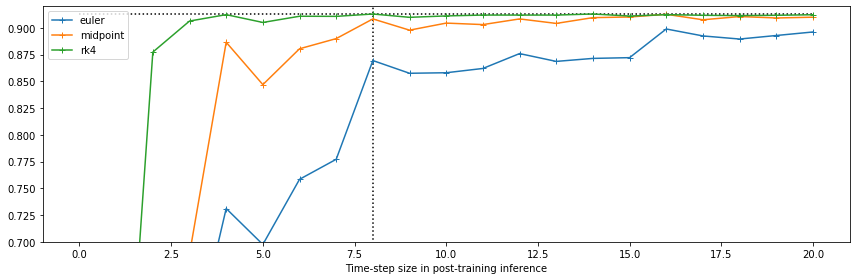

results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-8-1.0-1-piecewise-LEARN-0.05-200-[]-0.0-Backprop-NormalInit-SEED-1.pkl


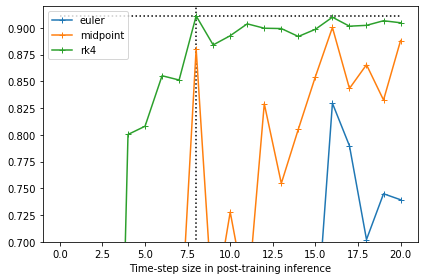

results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.05-160-[50, 100]-0.0-Backprop-NormalInit-SEED-1.pkl


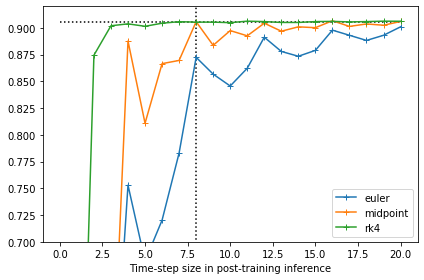

results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.05-160-[60, 120]-0.0-Backprop-NormalInit-SEED-1.pkl


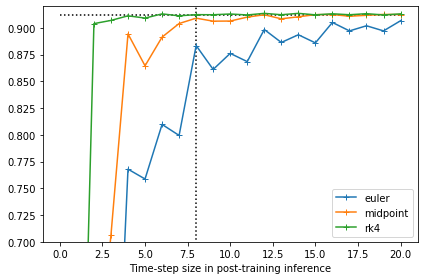

results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-1-1.0-1-piecewise-LEARN-0.05-160-[10, 40, 60, 80]-0.0-Backprop-NormalInit-SEED-1.pkl


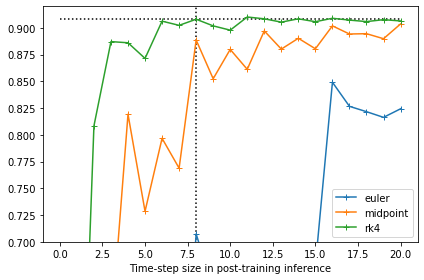

In [81]:
plt.figure(figsize=(12,4))
for name, accs_for_scheme in test_sweep.items():
    print(name)
#     if "[40, 80]" in name:
#         plt.subplot(132)
#         plt.title("Trained with refinement 40")
#     elif "[50, 100]" in name:
#         plt.subplot(133)
#         plt.title("Trained with refinement 50")
#     else:
#         plt.subplot(131)
#         plt.title("Trained without refinement")
#         plt.ylabel('Test set accuracy')
    for scheme, accs in accs_for_scheme.items():
        x,y = zip(*accs)
        #if scheme in name:
        #    plt.semilogx(1.0/x[0],y[0],'o')
        # plt.vlines([3.0],0,1,linestyle='dotted')
        # plt.plot(x, y, label=scheme)

        if scheme in name:
            plt.hlines([y[7]],0,20.0, linestyles='dotted')
        # plt.semilogx([1.0/_x for _x in x], y, '+-', label=scheme)
        plt.plot(x, y, '+-', label=scheme)

    #plt.vlines([1.0/8.0],0,1,linestyles='dotted')
    plt.vlines([8.0],0,1,linestyles='dotted')
    plt.ylim(0.7,0.92)
    plt.legend()
    plt.xlabel('Time-step size in post-training inference')
    plt.tight_layout()
    plt.show()

In [26]:
set_ode_config(result.model_list[-1], 8, 'rk4_classic', use_adjoint=False)

In [27]:
result.model_list[0].net[2].net.L1.weight.shape

torch.Size([2, 16, 16, 3, 3])

results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.05-200-[40, 80]-0.0-Backprop-NormalInit-SEED-1.pkl


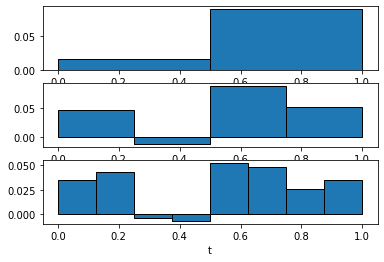

results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-8-1.0-1-piecewise-LEARN-0.05-200-[]-0.0-Backprop-NormalInit-SEED-1.pkl


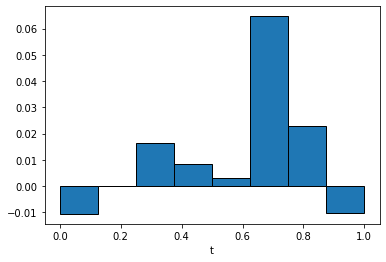

results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.05-160-[50, 100]-0.0-Backprop-NormalInit-SEED-1.pkl


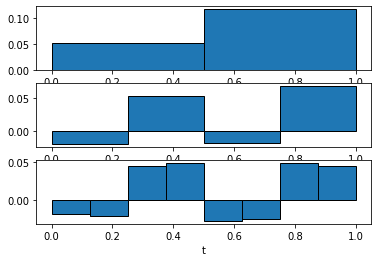

results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.05-160-[60, 120]-0.0-Backprop-NormalInit-SEED-1.pkl


ValueError: shape mismatch: objects cannot be broadcast to a single shape

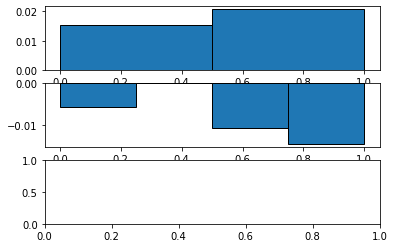

In [82]:
for name,result in results.items():
    i,j=0,0
    for a,b in [(2,2)]: #np.ndindex(result.model_list[0].net[2].net.L1.weight.shape[-2:]):
        print(name)
        plotting.plot_weights_over_time(
            result.model_list,
            lambda x : x.net[4].net.L1.weight[:,i,j,a,b].cpu(),
            lambda x : x.net[4].ts.cpu())


# Adjoint accuracy

In [64]:
criterion = torch.nn.CrossEntropyLoss()

In [65]:
def get_flat_grad(model):
    return torch.cat([ l.grad.flatten() for l in model.parameters() ])
def grad_wrt(model):
    model.zero_grad()
    out = model(imgs)
    L = criterion(out,labels)
    L.backward()
    return get_flat_grad(model)

In [69]:
name, result = next(iter(results.items()))

In [70]:
model = result.model_list[-1]
device = helper.which_device(model)
imgs, labels = next(iter(testloader))
imgs = imgs.to(device)
labels = labels.to(device)

In [90]:
name

'results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-1-1.0-1-piecewise-LEARN-0.01-100-[50]-0.1-Backprop-NormalInit-SEED-1.pkl'

In [72]:
auto_grad

tensor([-0.0428, -0.0359, -0.0679,  ...,  0.0033, -0.0067, -0.0251],
       device='cuda:0')

In [103]:
nts = range(1,10)
approxes = {}
set_ode_config(model, 2, 'rk4_classic', False)
auto_grad = grad_wrt(model)
denominator = np.linalg.norm(auto_grad.cpu().numpy())
for scheme in ['rk4_classic', 'euler']:
    approxes[scheme] = []
    for i in nts:
        set_ode_config(model, i, scheme, True)
        approx_grad = grad_wrt(model)
        err = np.linalg.norm((auto_grad - approx_grad).cpu().numpy())/denominator
        approxes[scheme].append(err)

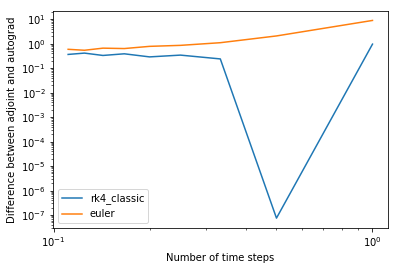

In [104]:
for scheme, approx in approxes.items():
    plt.loglog([1.0/_t for _t in nts],approx,label=scheme)
plt.xlabel("Number of time steps")
plt.ylabel("Difference between adjoint and autograd")
plt.legend()

In [95]:
approxes

{'rk4_classic': [0.9612521,
  7.302864e-08,
  0.23930673,
  0.34233332,
  0.28953344,
  0.387224,
  0.331518,
  0.41345862,
  0.3651575],
 'euler': [3.862687,
  9.624391e-08,
  0.780233,
  0.77960616,
  0.89037,
  0.86943847,
  0.9286262,
  0.9085805,
  0.9435202]}

In [105]:
nts = range(1,10)
approxes = {}

denominator = np.linalg.norm(auto_grad.cpu().numpy())
for scheme in ['rk4_classic', 'euler']:
    approxes[scheme] = []
    for i in nts:
        set_ode_config(model, i, scheme, False)
        auto_grad = grad_wrt(model)
        set_ode_config(model, i, scheme, True)
        approx_grad = grad_wrt(model)
        err = np.linalg.norm((auto_grad - approx_grad).cpu().numpy())/denominator
        approxes[scheme].append(err)

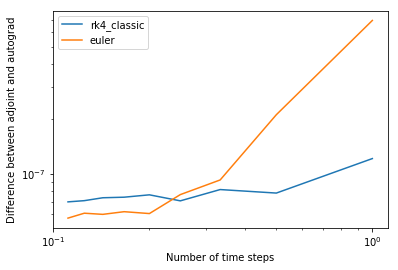

In [106]:
for scheme, approx in approxes.items():
    plt.loglog([1.0/_t for _t in nts],approx,label=scheme)
plt.xlabel("Number of time steps")
plt.ylabel("Difference between adjoint and autograd")
plt.legend()